In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [10]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [15]:
# set up inspector to better understand the columns in each table
inspector = inspect(engine)

measurement_columns = inspector.get_columns('measurement')
print("Measurement Table Columns:")
for column in measurement_columns:
    print(column['name'], column['type'])

station_columns = inspector.get_columns('station')
print(" ")
print("Station Table Columns")
for column in station_columns:
    print(column['name'], column['type'])
    
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(" ")
print(most_recent_date[0])


Measurement Table Columns:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
 
Station Table Columns
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
 
2017-08-23


In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d') - dt.timedelta(days=365)
print(f'Last Twelve Months: {one_year_ago}')

# Perform a query to retrieve the data and precipitation scores
selection = [measurement.date, measurement.prcp]
precip = session.query(*selection).filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip)

# Sort the dataframe by date
precip_df.sort_values(['date'], ascending = False, inplace=True)
precip_df.dropna(how='any', inplace=True)
final_precip_df = precip_df.set_index('date')
final_precip_df.head(10)

Last Twelve Months: 2016-08-23 00:00:00


,prcp
date,
2017-08-23,0.45
2017-08-23,0.08
2017-08-23,0.00
2017-08-23,0.00
2017-08-22,0.00
2017-08-22,0.50
2017-08-22,0.00
2017-08-21,0.56
2017-08-21,0.02


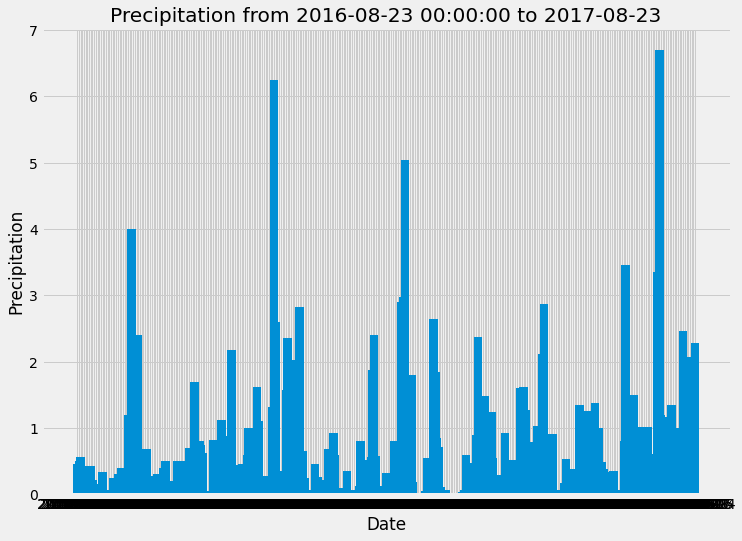

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(11, 8))
plt.bar(precip_df.date, precip_df.prcp, width=5)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title(f'Precipitation from {one_year_ago} to {most_recent_date[0]}')
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
final_precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station.station).count()
print(f'The total number of stations is {total_stations}')

The total number of stations is 9


In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = [measurement.station, func.count(measurement.station)]
most_active_stations = session.query(*active_stations).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active_stations_df = pd.DataFrame(most_active_stations, columns=['station', 'count'])
most_active_stations_df.head(10)

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
max_count_station = most_active_stations_df['count'].max()
print(f' The max count is {max_count_station}')
most_active_station = most_active_stations_df[most_active_stations_df['count'] == max_count_station]
most_active_station_id = most_active_station['station'][0]
print(f'The most active station ID is {most_active_station_id}')

tobs = [measurement.station, func.max(measurement.tobs), func.min(measurement.tobs), func.avg(measurement.tobs)]
max_temps_for_most_active_stations = session.query(*tobs).group_by(measurement.station)
max_temps_for_most_active_stations_df = pd.DataFrame(max_temps_for_most_active_stations, columns=['station_id', 'max_temp', 'min_temp', 'avg_temp'])
final_max_temp_for_most_active_station_df = max_temps_for_most_active_stations_df[max_temps_for_most_active_stations_df['station_id'] == most_active_station['station'][0]]
final_max_temp_for_most_active_station_df.head()

 The max count is 2772
The most active station ID is USC00519281


,station_id,max_temp,min_temp,avg_temp
6,USC00519281,85.0,54.0,71.663781


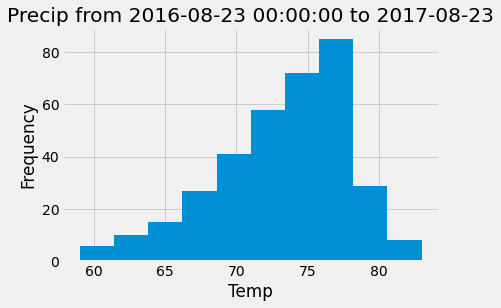

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = [measurement.station, measurement.tobs]
temps = session.query(*data).filter(measurement.date > one_year_ago)
temps_df = pd.DataFrame(temps, columns= ['station', 'temp'])
final_temps_df = temps_df[temps_df['station']==most_active_station['station'][0]]
plt.hist(final_temps_df['temp'])
plt.xlabel('Temp')
plt.ylabel('Frequency')
plt.title(f'Precip from {one_year_ago} to {most_recent_date[0]}')
plt.show()

# Close session

In [23]:
# Close Session
session.close()